# Analysis of manually-defined control policy
Nok Wongpiromsarn, 3 March 2020

## Problem description
This example illustrates the use of TuLiP interface to stormpy to analyze a probabilistic model obtained by imposing a manually-defined control policy on an MDP.

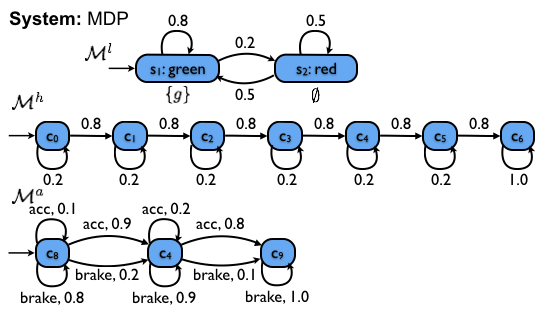

**Specification:** Vehicle *a* does not collide with vehicle *h* and is not at *c8* or *c4* when the light is *red* until it reaches *c6*

We begin by importing the packages and modules that we will need.

In [1]:
import os
import json
from tulip.interfaces import stormpy as stormpy_int
from tulip.transys.compositions import synchronous_parallel, apply_policy
from tulip.transys.mathfunc import FunctionOnLabeledState

`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.


Define a convenient function to parse a json file

In [2]:
def parse_policy_json(path, tulip_model):
    with open(path) as f:
        policy_json = json.load(f)

    policy = FunctionOnLabeledState("state", "action")
    for labels_action in policy_json.values():
        ap = set(labels_action["labels"])
        state = next(
            (
                state
                for state in tulip_model.states
                if tulip_model.states[state]["ap"] == ap
            ),
            None,
        )
        action = str(labels_action["action"])
        policy.add(state, action, ap)

    return policy

Set up paths to all the models

In [3]:
model_path = os.path.join("/home/ubuntu/eeci/c1-probabilistic", "models")
ma_path = os.path.join(model_path, "ma.nm")
mh_path = os.path.join(model_path, "mh.pm")
light_path = os.path.join(model_path, "light.pm")

Build models from prism files

In [4]:
ma = stormpy_int.to_tulip_transys(ma_path)
mh = stormpy_int.to_tulip_transys(mh_path)
light = stormpy_int.to_tulip_transys(light_path)

Compose models

In [5]:
composed = synchronous_parallel([ma, mh, light])

Specify property: "Vehicle a does not collide with vehicle h and is not at c8 or c4 when the light is red until it reaches c6"

In [6]:
safety = '!("h4" & "a4") & !("red" & ("a8" | "a4"))'
reach = '"a9"'
formula = 'P=? [ ({}) U ({}) ]'.format(safety, reach)

Get the MC induced by applying policy on model

In [7]:
policy_path = os.path.join(model_path, "policy.json")
policy = parse_policy_json(policy_path, composed)
induced_mc = apply_policy(composed, policy)

Run model checking

In [8]:
out_model_path = os.path.join(model_path, "out_composed_model.nm")
result = stormpy_int.model_checking(induced_mc, formula, out_model_path)

Examine result

In [9]:
for state in induced_mc.states:
    print("  State {}, with labels {}, Pr = {}".format(state, induced_mc.states[state]["ap"], result[state]))

  State ('s1', 's1', 's1'), with labels {'h1', 'red', 'a4'}, Pr = 0.0
  State ('s1', 's1', 's0'), with labels {'h1', 'green', 'a4'}, Pr = 0.9501789664595234
  State ('s1', 's2', 's1'), with labels {'red', 'a4', 'h2'}, Pr = 0.0
  State ('s1', 's2', 's0'), with labels {'green', 'a4', 'h2'}, Pr = 0.9357284338501467
  State ('s1', 's0', 's1'), with labels {'h0', 'red', 'a4'}, Pr = 0.0
  State ('s1', 's0', 's0'), with labels {'h0', 'green', 'a4'}, Pr = 0.9520897806888625
  State ('s1', 's3', 's1'), with labels {'red', 'h3', 'a4'}, Pr = 0.0
  State ('s1', 's3', 's0'), with labels {'h3', 'green', 'a4'}, Pr = 0.8264462809917354
  State ('s1', 's5', 's1'), with labels {'red', 'h5', 'a4'}, Pr = 0.0
  State ('s1', 's5', 's0'), with labels {'h5', 'green', 'a4'}, Pr = 0.9523809523809523
  State ('s1', 's6', 's1'), with labels {'red', 'h6', 'a4'}, Pr = 0.0
  State ('s1', 's6', 's0'), with labels {'h6', 'green', 'a4'}, Pr = 0.9523809523809521
  State ('s1', 's4', 's1'), with labels {'red', 'a4', 'h4'